# Clustering Lyrical Data

# 1: Introduction and Limitations

The **goal** of this project is to *find topics from a corpus of song lyric data using unsupervised modeling techniques, and from those topics, find common clusters for the lyrics and potentially create tags for songs*. The data source for this project is the [380,000+ Lyrics from MetroLyrics](https://www.kaggle.com/gyani95/380000-lyrics-from-metrolyrics) dataset collected by the Kaggle user [GyanendraMishra](https://www.kaggle.com/gyani95). There are many questions to consider when modeling with this type of data. 
- How will the lyrics be represented?
- What models should be used in this case?
- How will the models interpret the lyrics? 
- How will the models differentiate between the lyrics? 
- How is a model's effectiveness measured?
- What is the "best" model?
- What are the limitations to this method?

I hope to answer most of the above questions with this project.

First off, a few quick and easy definitions of words that will be commonly used in the project:
- Lyrics/text/words: these will be used relatively interchangeably and could refer to either the string form of the data or tokenized form of data (essentially, these are the words in the songs)
- Corpus: The entire collection of lyrics (i.e. all the songs)

It is important to define the kind of data that is being worked with as well as the limitations of the data. This data is a collection of lyrics that was scraped from the MetroLyrics website. It is not cleaned and is in its raw textual format. Some lyrics, if not all, have initially been entered (typed) by hand and thus may contain misspellings and errors. This data is not perfect, but should be a useful base for topic modeling and clustering songs by their lyrical content. With that said, there are other limitations that will be set on the initial dataset.

Further scope and limitations of the project are as follows:
1. Any songs prior to 2006 will be removed (10 year range)
2. Non-English songs will be removed
3. Non-lyrics and N/A data will be removed
4. Extremely long and extremely short lyrics will be removed
5. It's not going to be perfect (but it should be pretty good)

This notebook's goal is to understand the contents of the raw dataset and transform it in a way that is conducive to the next stage of the project (Text Cleaning and Data Exploration).

In [41]:
#standard imports
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from langdetect import detect #for language detection

In [4]:
%%capture

#tqdm is used to display progress bar for pandas apply
from tqdm import tqdm
try:
    tqdm._instances.clear()
    tqdm.pandas()
except:
    tqdm.pandas()

Import dataset.

In [8]:
data = pd.read_csv(r'C:\Users\philb\Repos\Thinkful_repo\projects\unsupervised_capstone\source\data.csv').iloc[:, 1:]

## 1.1: Scratching the Surface or: Getting a "Feel" for the Data

Quick look at the raw dataset - head, tail and shape.

In [9]:
data.head()

,song,year,artist,genre,lyrics
0,ego-remix,2009,beyonce-knowles,Pop,"Oh baby, how you doing?\nYou know I'm gonna cu..."
1,then-tell-me,2009,beyonce-knowles,Pop,"playin' everything so easy,\nit's like you see..."
2,honesty,2009,beyonce-knowles,Pop,If you search\nFor tenderness\nIt isn't hard t...
3,you-are-my-rock,2009,beyonce-knowles,Pop,"Oh oh oh I, oh oh oh I\n[Verse 1:]\nIf I wrote..."
4,black-culture,2009,beyonce-knowles,Pop,"Party the people, the people the party it's po..."


In [10]:
data.tail()

,song,year,artist,genre,lyrics
362232,who-am-i-drinking-tonight,2012,edens-edge,Country,"I gotta say\nBoy, after only just a couple of ..."
362233,liar,2012,edens-edge,Country,I helped you find her diamond ring\nYou made m...
362234,last-supper,2012,edens-edge,Country,Look at the couple in the corner booth\nLooks ...
362235,christ-alone-live-in-studio,2012,edens-edge,Country,When I fly off this mortal earth\nAnd I'm meas...
362236,amen,2012,edens-edge,Country,I heard from a friend of a friend of a friend ...


In [12]:
data.shape

(362237, 5)

Interestingly, the "380,000+" lyrics actually only turns out to be 362,237 lyrics, close enough, I guess.

In [13]:
data.song

0                           ego-remix
1                        then-tell-me
2                             honesty
3                     you-are-my-rock
4                       black-culture
                     ...             
362232      who-am-i-drinking-tonight
362233                           liar
362234                    last-supper
362235    christ-alone-live-in-studio
362236                           amen
Name: song, Length: 362237, dtype: object

The song column unsurprisingly indicates the song title, presumably in a format that is URL friendly: all lowercase, spaces represented by the "-" character.

In [21]:
print(data.year)
print()
print(f'Min Year: {data.year.min()}, Max Year: {data.year.max()}')

0         2009
1         2009
2         2009
3         2009
4         2009
          ... 
362232    2012
362233    2012
362234    2012
362235    2012
362236    2012
Name: year, Length: 362237, dtype: int64

Min Year: 67, Max Year: 2038


The year appears to indicate when a song was released based on the website's records. Some of these are definitely not accurate as displayed by the minimum and maximum year!

In [22]:
data.year.value_counts()

2006    76590
2007    63677
2016    37409
2015    28766
2014    28250
2008    21497
2013    17331
2012    15789
2010    12106
2011    12067
2009    12029
2005     5719
2004     3698
2003     2187
2002     2158
2000     1722
1999     1586
2001     1570
1990     1362
1997     1304
1998     1285
1996     1236
1995     1160
1994      968
1993      918
1992      907
1991      559
1977      552
1971      541
1973      520
1989      511
1972      509
1982      498
1970      429
1979      420
1981      414
1974      410
1978      407
1980      401
1988      388
1986      365
1975      364
1983      359
1976      344
1985      333
1987      307
1984      298
2038       10
112         4
702         1
1968        1
67          1
Name: year, dtype: int64

After looking at this, it looks like there are a decent amount of non-sensical year values, as stated in the introduction, the years will be limited from 2006 to 2016. Why 2006 to 2016? It's just an arbitrary decision. Based on the value counts, every year from 2006 to 2016 has over 10,000 songs. So those years with a decently sized sample will be the ones included.

**Limiting years:**

In [29]:
limit_years = data[(data.year < 2017) & (data.year > 2005)].copy()

In [31]:
limit_years.artist

0         beyonce-knowles
1         beyonce-knowles
2         beyonce-knowles
3         beyonce-knowles
4         beyonce-knowles
               ...       
362232         edens-edge
362233         edens-edge
362234         edens-edge
362235         edens-edge
362236         edens-edge
Name: artist, Length: 325511, dtype: object

The artist column is very similar to the song column, URL friendly artist names.

In [38]:
limit_years.genre.value_counts()

Rock             116063
Pop               44847
Hip-Hop           31479
Not Available     27689
Metal             26946
Other             20751
Country           15661
Electronic        14979
Jazz              13708
Indie              5527
R&B                4915
Folk               2946
Name: genre, dtype: int64

Looks like there is a massive amount of "Rock" music. I put "Rock" in quotes because who knows how accurate the genre descriptions are? These may be good guidelines, but they shouldn't be taken literally or hold much weight in the comparison between lyrics, generally speaking.

**Removing N/A:**

In [43]:
limit_years.lyrics.isna().sum()

83154

A decent chunk of these lyrics are simply empty, those should be removed.

In [45]:
no_na = limit_years[~limit_years.lyrics.isna()].copy()

In [52]:
(data.shape[0] - no_na.shape[0]) / data.shape[0]

0.3309435535298713

By those two simple actions: limiting the years and dropping empty lyrics, a solid chunk of original entries have been removed!

In [64]:
no_na.isna().sum()

song      1
year      0
artist    0
genre     0
lyrics    0
dtype: int64

Looks like one song doesn't have a title, that can be fixed.

In [70]:
no_na[no_na.song.isna()]

,song,year,artist,genre,lyrics
193957,NaN,2009,booker-t-and-the-mg-s,Jazz,"All right people, the rest of the hard working..."


A quick google search shows that song is called "Green Onions" and it was released in 1962! Not sure why it is indicated to be 2009. This song will be dropped.

In [72]:
no_na.drop(labels=193957, inplace=True)

In [73]:
no_na.isna().sum()

song      0
year      0
artist    0
genre     0
lyrics    0
dtype: int64

Now, no_na truly contains no N/As.

**Dealing with duplicates:**

In [95]:
no_na[no_na.song.str.contains('remix')]

,song,year,artist,genre,lyrics
0,ego-remix,2009,beyonce-knowles,Pop,"Oh baby, how you doing?\nYou know I'm gonna cu..."
22,beutiful-liar-remix,2007,beyonce-knowles,Pop,Ay! Ay!\n(Nobody likes being played)\nAy!\nOh!...
49,irreemplazable-nortena-remix,2007,beyonce-knowles,Pop,"Ya lo ves, ya lo ves\nTe olvid, te olvid, mmm\..."
88,run-the-world-girls-remix,2012,beyonce-knowles,Pop,"Girls, we run this motha\nGirls, we run this m..."
111,in-da-club-remix,2006,beyonce-knowles,Pop,"No shorty, it's Beyonce\nWe gon' party like, i..."
...,...,...,...,...,...
361158,it-s-over-now-remix,2006,112,Hip-Hop,What is this?\nNumbers in your pocket\nI remem...
361163,u-already-know-remix,2006,112,Hip-Hop,Papa comin' over to give you that raw\nFavorit...
361175,hot-wet-remix,2006,112,Hip-Hop,"I wanna show you how I feel, don't hold back, ..."
361947,blame-phentinol-warzone-pharmaceuticals-remix,2006,gravity-kills,Rock,I thought I could hear you\nEchoing words of d...


Looks like a song with remix in the title is probably just a remix of the actual song, these will be removed.

In [105]:
no_na[no_na.song.str.contains('-studio')]

,song,year,artist,genre,lyrics
34153,elias-live-in-studio,2006,dispatch,Rock,Dai Jesu achoinekwa ndaizofara naye\nDai Jesu ...
38331,always-be-my-baby-studio-version,2008,david-cook,Rock,"We were as one, babe for a moment in time\nAnd..."
69919,haunted-live-at-diversion-studios,2015,ben-montague,Rock,All you said and all you did to me\nWas a ston...
81942,solicitor-in-studio,2006,fall,Metal,Young dicks make TV\nGet 'em away from me\nYou...
95461,home-studio-back-up-in-this-bitch,2014,chance-the-rapper,Pop,[Intro]\nUh uh uh uh uh\nIGH!\nNana naaaaa\nYu...
95462,home-studio,2014,chance-the-rapper,Pop,[Intro]\nUh uh uh uh uh uh\nIGH!\nNana naaaaa\...
100291,quando-sorpresa-gli-allestisci-uno-studio-di-p...,2013,casa-degli-specchi,Hip-Hop,[Verse 1: GyLuciani]\nPrendo una Heineken / e ...
106916,you-ve-got-a-friend-studio-version,2008,brooke-white,Pop,"When you're down, in trouble. And you need som..."
106917,here-comes-the-sun-studio-version,2008,brooke-white,Pop,Here comes the sun. Doo doo doo doo. Here come...
106918,every-breath-you-take-studio-version,2008,brooke-white,Pop,Every breath you take and every move you make....


Pretty much the same deal here. Few exceptions.

In [104]:
no_na[no_na.song.str.contains('-version')]

,song,year,artist,genre,lyrics
20,beautiful-liar-spanglish-version,2007,beyonce-knowles,Pop,Ay! Ay!\n(Nobody likes being played)\nAy!\nOh!...
31,bello-embustero-beautiful-liar-spanish-version,2007,beyonce-knowles,Pop,"Ay! Ay! Ay!\nOh! Beyonce, Beyonce\nOh! Beyonce..."
48,oye-listen-spanish-version,2007,beyonce-knowles,Pop,"Oye, lo que tengo que decir\nNo puedo ya segui..."
51,irreemplazable-irreplaceable-spanish-version,2007,beyonce-knowles,Pop,"To the left, to the left\nTo the left, to the ..."
122,irremplazable-irreplaceable-spanish-version,2006,beyonce-knowles,Pop,"To the left, to the left\nTo the left, to the ..."
...,...,...,...,...,...
357181,paris-blues-live-version,2016,duke-ellington,Jazz,"Left bank caf,\nStrollin the quays,\nWatching ..."
357692,sin-love-and-the-devil-album-version,2007,embraze,Metal,Rain beats me down\nI cry for my sins and love...
358325,ich-bin-in-dir-version-2001,2006,brthhse-onkelz,Rock,Hrst Du diese Lieder\nBhse Onkelz immer wieder...
358632,saint-claude-english-version,2016,christine-and-the-queens,Electronic,Souffle saccadÃ©\nVoilÃ qui laisse deviner\nQ...


And again.

In [108]:
no_na = no_na[~no_na.song.str.contains('remix')].copy()
no_na = no_na[~no_na.song.str.contains('-studio')].copy()
no_na = no_na[~no_na.song.str.contains('-version')].copy()

In [112]:
no_na.lyrics.duplicated().sum()

15589

Looks like a decent amount of these lyrics are just duplicates of one another, the number may actually be a bit higher if the lyrics lowered and stripped of extra white space.

In [113]:
no_na.lyrics.apply(lambda x: ' '.join(x.lower().split())).duplicated().sum()

16000

Over 400 more songs are actually duplicates. First, randomly shuffle the data before eliminating duplicates.

In [115]:
shuffle_data = no_na.sample(frac=1.0, random_state=234).copy()

In [118]:
no_duplicates = shuffle_data[~shuffle_data.lyrics.apply(lambda x: ' '.join(x.lower().split())).duplicated()].copy()

**Extreme song lengths:**

In [131]:
song_length = no_duplicates.lyrics.apply(lambda x: len(' '.join(x.split())))
song_length.describe()

count    223299.000000
mean       1154.665180
std         786.932232
min           1.000000
25%         669.000000
50%         973.000000
75%        1400.000000
max       42131.000000
Name: lyrics, dtype: float64

Looks like there are really long songs as well as short songs. Extreme cases should be removed!

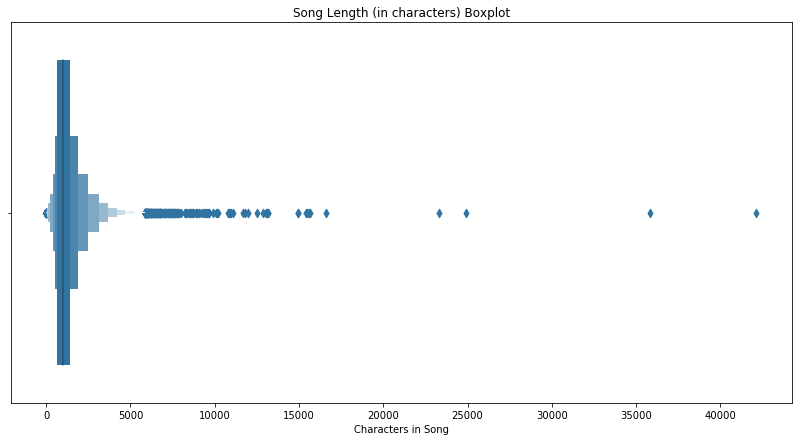

In [169]:
plt.figure(figsize=(14, 7))
sns.boxenplot(song_length)
plt.title('Song Length (in characters) Boxplot')
plt.xlabel('Characters in Song')
plt.xticks(ticks=range(0, 45000, 5000))
plt.show()

Perhaps best to remove the highest 5% of songs as well as the lowest 5%.

In [154]:
fifth_percentile = round(len(song_length)*.05)
ninety_fifth_percentile = round(len(song_length)*.95)

In [155]:
keep_indicies = song_length.sort_values().iloc[fifth_percentile:ninety_fifth_percentile].index

In [156]:
drop_extreme = no_duplicates.loc[keep_indicies].copy()

In essense, this has removed extreme cases for song length, somewhat normalizing the selection.

In [163]:
new_song_lengths = drop_extreme.lyrics.apply(lambda x: len(' '.join(x.split())))

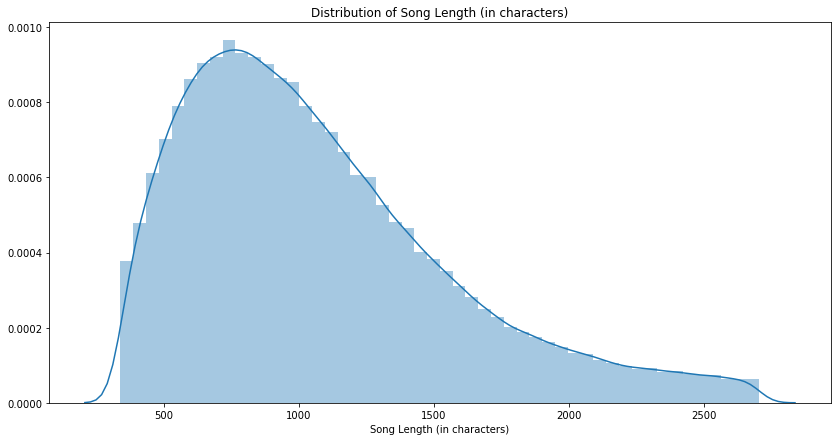

In [167]:
plt.figure(figsize=(14,7))
sns.distplot(new_song_lengths)
plt.title('Distribution of Song Length (in characters)')
plt.xlabel('Song Length (in characters)')
plt.show()

From the above, it is still clear that most songs are on the shorter end than the longer end.

**Languages:**

In [176]:
language = drop_extreme.lyrics.progress_apply(detect)

100%|█████████████████████████████████████████████████████████████████| 200969/200969 [50:29<00:00, 66.34it/s]


Finally, only English songs will be included in the analysis. So all songs that aren't English will be removed. The langdetect package comes in handy here!

In [181]:
english_indicies = language[language == 'en'].index

In [183]:
final_data = drop_extreme.loc[english_indicies].copy()

## 1.2: Export Deliverable

In [184]:
final_data.shape[0] / data.shape[0]

0.504766216593004

When all is said and done, about half of the original entries/rows/songs remain. This dataset can be exported locally and pickled for use in the next notebook.

In [185]:
final_data.to_pickle(r'C:\Users\philb\Repos\Thinkful_repo\projects\unsupervised_capstone\pickle\data\scoped_data.pkl')